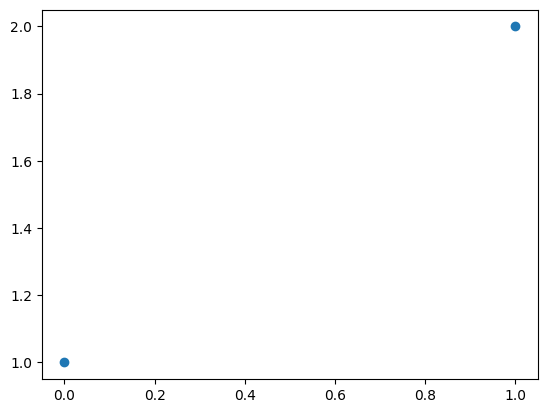

In [1]:
import sys
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seis-library/')
import kaggle_support as kgs
import importlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import os
import seis_forward
import seis_test
plt.scatter([0,1],[1,2])
#fls.download_kaggle_dataset('jeroencottaar/byu-many-models-2/', fls.result_dir + '/many_full_res/')

In [3]:
importlib.reload(seis_test)
seis_test.run_all_tests(test_reference_mode=False)

3.544453883175856e-05
All tests passed!


In [4]:
importlib.reload(kgs)
data = kgs.Data()
data.seismogram.filename = 'F:\\seismic\\data\\train_samples\\FlatVel_A/data\\data1.npy'
data.seismogram.ind=5
data.velocity = kgs.Velocity()
data.velocity.filename = 'F:\\seismic\\data\\train_samples\\FlatVel_A/model\\model1.npy'
data.velocity.ind=5
data.check_constraints()
data.load_to_memory()
#data.unload()

In [5]:
data.seismogram.data.shape

(5, 999, 70)

In [6]:
5*999*70

349650

In [3]:
importlib.reload(kgs)
data=kgs.load_all_train_data()
print(len(data))
for d in data:
    d.check_constraints()

10000


In [4]:
# Demonstrate Jacobian
kgs.profiling=True
d = data[2059]
d.load_to_memory()
_,p_complete = seis_forward.vel_to_seis(d.velocity, d.seismogram, return_p_complete_list=True)  
J = seis_forward.vel_to_seis_diff(d.velocity, d.seismogram, p_complete, cp.eye(4901,dtype=kgs.base_type_gpu)[:100,:])

Timer unit: 1e-07 s

Total time: 1.21743 s
File: f:\seismic/code/core\seis_forward.py
Function: vel_to_seis at line 204

Line #      Hits         Time  Per Hit   % Time  Line Contents
   204                                           @kgs.profile_each_line
   205                                           def vel_to_seis(velocity,seismogram,return_p_complete_list=False):
   206         1        415.0    415.0      0.0      velocity.check_constraints()
   207         1        302.0    302.0      0.0      seismogram.check_constraints()
   208         1          2.0      2.0      0.0      seis_combined = []
   209         1     228284.0 228284.0      1.9      temp1,temp2,alpha,s_mod=prep_run(velocity)
   210                                               
   211         1        171.0    171.0      0.0      temp1_flat= temp1.ravel()
   212         1         15.0     15.0      0.0      temp2_flat= temp2.ravel()
   213         1          9.0      9.0      0.0      alpha_flat= alpha.ravel()
   

NameError: name 'cp' is not defined

In [8]:
%%time
importlib.reload(seis_forward)
kgs.profiling=True
d = data[2059]
print(d.family)
d.load_to_memory()
#seis_pred = seis_forward.vel_to_seis(data[0].velocity.data, data[0].velocity.min_vel)
for ind in range(10):
    seis_pred = seis_forward.vel_to_seis(d.velocity, d.seismogram)[0].data
    kgs.profiling=False
#seis_pred = seis_forward.vel_to_seis(data[0].velocity.data,data[0].velocity.min_vel)[:,2:,:]
kgs.rms(seis_pred[:,:,:]-d.seismogram.data[:,:,:])    

CurveVel_A
Timer unit: 1e-07 s

Total time: 0.379508 s
File: f:\seismic/code/core\seis_forward.py
Function: vel_to_seis at line 204

Line #      Hits         Time  Per Hit   % Time  Line Contents
   204                                           @kgs.profile_each_line
   205                                           def vel_to_seis(velocity,seismogram,return_p_complete_list=False):
   206         1        706.0    706.0      0.0      velocity.check_constraints()
   207         1        657.0    657.0      0.0      seismogram.check_constraints()
   208         1          3.0      3.0      0.0      seis_combined = []
   209         1      18028.0  18028.0      0.5      temp1,temp2,alpha,s_mod=prep_run(velocity)
   210                                               
   211         1         93.0     93.0      0.0      temp1_flat= temp1.ravel()
   212         1         29.0     29.0      0.0      temp2_flat= temp2.ravel()
   213         1         24.0     24.0      0.0      alpha_flat= alpha

array(3.54445388e-05)

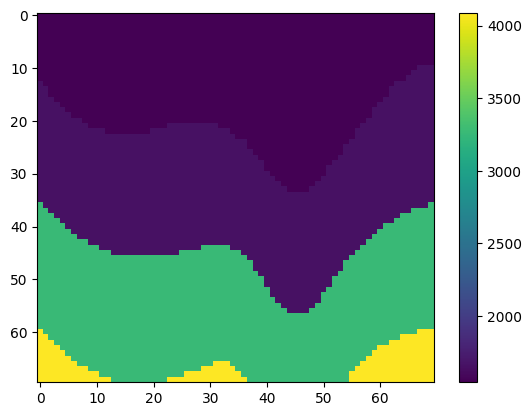

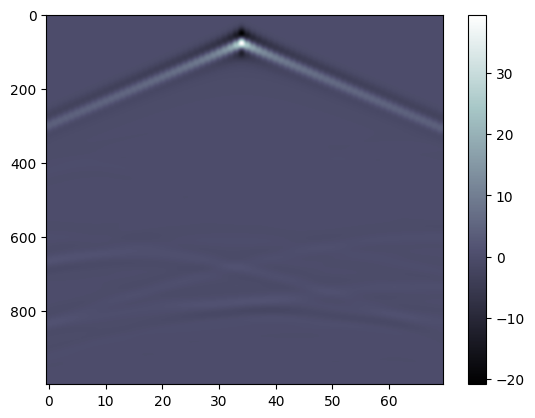

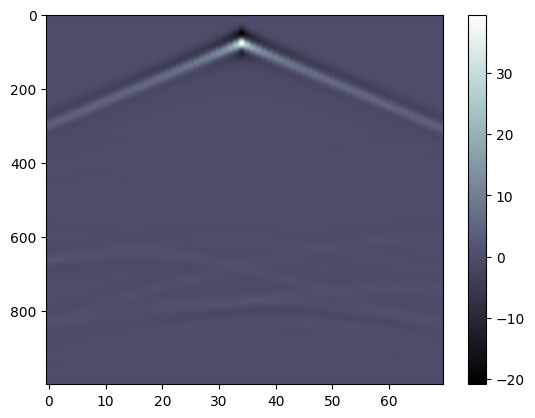

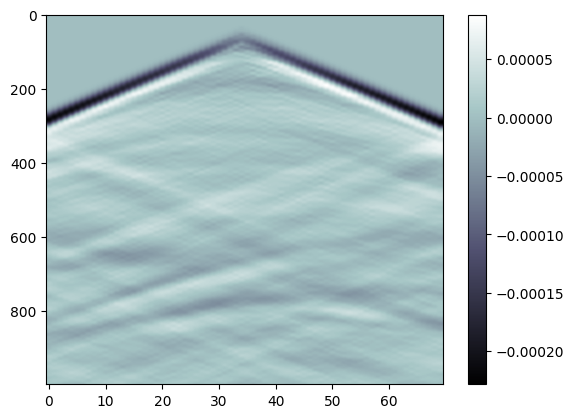

In [9]:
import cupy as cp
plt.figure();plt.imshow(cp.asnumpy(d.velocity.data),aspect='auto');plt.colorbar()
plt.figure();plt.imshow(cp.asnumpy(d.seismogram.data[2,...]),cmap='bone',aspect='auto');plt.colorbar()        
plt.figure();plt.imshow(cp.asnumpy(seis_pred[2,...]),cmap='bone',aspect='auto');plt.colorbar()     
plt.figure();plt.imshow(cp.asnumpy(seis_pred[2,:,:]-d.seismogram.data[2,...]),cmap='bone',aspect='auto');plt.colorbar()

In [ ]:
data_shuffled = copy.deepcopy(data)
#np.random.default_rng(seed=0).shuffle(data_shuffled)
families = list(dict.fromkeys([d.family for d in data]))
for f in families:
    n_ok = 0
    n_done = 0
    for i,d in enumerate(data_shuffled):
        if not d.family==f:
            continue
        d.load_to_memory()
        seis_pred = seis_forward.vel_to_seis(d.velocity,d.seismogram).data
        if kgs.rms(seis_pred[:,:,:]-d.seismogram.data[:,:,:])<1e-4:
            #print('OK')
            n_ok+=1
        else:            
            pass
            print(d.family, kgs.rms(seis_pred[:,:,:]-d.seismogram.data[:,:,:]))              
            plt.figure();plt.imshow(d.velocity.data,aspect='auto');plt.colorbar()
            plt.figure();plt.imshow(d.seismogram.data[2,...],cmap='bone',aspect='auto');plt.colorbar()        
            plt.figure();plt.imshow(seis_pred[2,:,:]-d.seismogram.data[2,...],cmap='bone',aspect='auto');plt.colorbar()
            plt.pause(0.001)
            print(i)
        d.unload()
        n_done += 1
        if n_done>=100:
            break
    print(f,n_ok, n_done, n_ok/n_done)